Test of concept before importing to google collab. 

## Set up

In [1]:
#Importing packages for later
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib.font_manager import FontProperties
import re

In [2]:
#Read in the scrape results
commercials_df = pd.read_csv('scrape_results.csv',sep = '\t')
#Read in the car brands and car models csv file. Note: we delted car: cars entry here
car_df = pd.read_csv('car models and brands.csv', names = ['car_brand','car_model'])

## Clean up section

In [3]:
#There are punctuation errors for the car brands (and also maybe car models). 
#Use re to clean that up.
car_df['car_brand'] = car_df['car_brand'].apply(lambda x: re.sub(r'[^\w\s]','',x))
car_df['car_model'] = car_df['car_model'].apply(lambda x: re.sub(r'[^\w\s]','',x))

#Drop any duplicates in the car models
car_df2 = car_df.drop_duplicates('car_model')

#Convert dataframe to a dictionary
prelim_dict = car_df2.set_index('car_model').to_dict('index')
#Idea is to have the key be the model. The value be the brand. If the key is in the comment then convert it into the brand.

#This may be inefficient but it works so...
#Create a new empty dictionary
model_to_brand_dict = {}
#Iterate over the prelim dictionary to make a new one.
for key,value in prelim_dict.items():
    for key1, value1 in value.items():
        model_to_brand_dict[key] = value1
        
#Now we have a model_to_brand_dict that we can convert models to brands with.

#We need to filter out stopwords
from nltk.corpus import stopwords
#Use nltk's stopwords list
stopwords_list = stopwords.words('english')

In [4]:
#clean_comment accepts a string. It then cleans the comment by removing punctuation and stopwords.
#It returns a list of words in that string.
def clean_comment(comment):
    #For cleaning up the test comment. Remove punctuation and make everything lower case.
    comment = re.sub(r'[^\w\s]','',comment.lower())
    
    #Syntax translation:
    #word can be anything. I choose word since it's what we're essentially doing
    #comment.split() converts the comment into a list. 
    #Then see if the word in that list is in the drop_stop or not. 
    #Drops any word that is in the stopwords list.
    stopwords_list = stopwords.words('english')
    #Store this list and return it.
    cleaned = [word for word in comment.split() if word not in stopwords_list]
    return cleaned

In [5]:
#Use function to create a new cleaned comment column.
commercials_df['cleaned comment'] = commercials_df['comments'].astype(str).apply(clean_comment)

In [6]:
#Function to replace all of the car models with car brands.
#Part 2 of cleaning comments.
#Could merge into clean comment but I feel this is more clear.
#model_to_brand takes a list of words as a parameter and a model_to_brand_dict.
#It then iterates over the list and sees if each word matches a key in the dictionary. 
#If the word is in the dictionary, it will be converted to a brand.
#Specifically, dict[key] gives the value of that key. In this case model: brand.
#Returns the word list converted 
def model_to_brand(word_list,word_dict=model_to_brand_dict):
    #Need initial index of -1 to get index 0 for the iteration
    index = -1
    for word in word_list: #Iterate for every word in the list
        index += 1
        if word in model_to_brand_dict: #word is a key in the dictionary
            #Convert key to value. Model to brand.
            word_list[index] = model_to_brand_dict[word]
    return word_list

In [7]:
#Using function to replace models with brands
commercials_df['cleaned comment'] = commercials_df['cleaned comment'].map(model_to_brand)

In [8]:
#Create an empty brand dictionary in order to count brands later
brand_dict = {}
for brand in car_df['car_brand'].drop_duplicates():
    brand_dict[brand] = 0

In [9]:
#Accepts a list of words as a parameter.
#Counts word occurrences and stores it as a dictionary which is returned.
def create_word_count(word_list):
    #Create dictionary that acts as the values for the main frame.
    word_frequency={}

    for word in word_list: #Take each word in the words list.
        if word in word_frequency: #If I have seen this word, update number of times seen by 1
            word_frequency[word] +=1
        else: #I have not seen this word yet. Put it in as a key value.
            word_frequency[word]  = 1
    return word_frequency

In [10]:
#Create a new column that contains the word frequency dictionaries
commercials_df['count dictionary'] = commercials_df['cleaned comment'].map(create_word_count)

## Top 10 brands, lift matrix, and MDS plot

$Lift(A,B) = \frac{n*num(A,B)}{num(A)*num(B)}$ where num stands for number of times occurred.

In [11]:
#Lift is calculated with the frequentist approach
#Parameters are two words: a and b
#3rd one is a series of dictionaries aka the commercials_df['count_dictionary']
#Put in as a default value.
def calc_lift(a,b,series_of_dictionaries = commercials_df['count dictionary']):
    #Define count variables
    count_a = 0
    count_b = 0
    count_ab = 0
    #Define total length of series which is also the number of messages
    n = len(series_of_dictionaries)
    if a == b: #A and b are the same word. The lift is 1.
        return 1
    #Otherwise iterate through the dictionaries
    #Count occurrences of a,b,(a,b) in the dictionary
    for dictionary in series_of_dictionaries:
        if a in dictionary: #a is in the dictionary. Add 1 to count_a
            count_a += 1
        if b in dictionary: #b is in the dictionary. Add 1 to count_b
            count_b += 1
        if a in dictionary and b in dictionary: #both a,b are in the dictionary. Add 1 to count_ab
            count_ab += 1
    try: #Try and except block because division by zero is technically possible.
        lift = (n*count_ab)/(count_a*count_b)
    except: #Happens if an error occurs
        #Dividing by zero. So either count_a or count_b is zero.
        #return a NaN value
        return np.NaN
    #return the lift
    return lift

In [12]:
#Count the number of times a brand has been mentioned in a message/comment throughout the entire df
for dictionary in commercials_df['count dictionary']: #Take each dictionary
    for key,value in dictionary.items(): #For each key (word) and value (frequency)
        if key in brand_dict: #The key matches the brand key. 
            #Add 1 to the value aka times it ocurred.
            brand_dict[key] += 1

In [13]:
#Uncomment to display the dictionary if you want to see it
#brand_dict

### Top Ten Brands

In [14]:
#Make a dataframe from the dicitonary
brand_df = pd.DataFrame.from_dict(brand_dict, orient = 'index').reset_index()
brand_df.columns = ['brand','frequency']
#Display the top ten brands
brand_df.sort_values('frequency',ascending=False).head(10)

,brand,frequency
30,toyota,547
9,honda,308
8,ford,302
5,chevrolet,298
11,hyundai,264
27,subaru,237
2,bmw,213
1,audi,156
31,volkswagen,151
21,nissan,149


### Lift matrix

In [15]:
#Store this as a dataframe.
top_ten = brand_df.sort_values('frequency',ascending=False).head(10)

#Create a top ten list to use in a dataframe to create a blank matrix
top_ten_list = []
for brand in top_ten['brand']:
    top_ten_list.append(brand)

#Create the empty matrix
lift_matrix = pd.DataFrame(index = top_ten_list, columns = top_ten_list)

#Uncomment if you want to see it
#lift_matrix

In [16]:
#Do a double for loop on the top_ten_list. To create the lift matrix
#Makes sure that each lift value is calculated for every brand.
for brand in top_ten_list: #Take brand
    for brand2 in top_ten_list: #match it with every brand in the list including itself.
        lift_matrix.loc[brand][brand2] = calc_lift(brand,brand2)

In [17]:
#Display the lift matrix
lift_matrix

,toyota,honda,ford,chevrolet,hyundai,subaru,bmw,audi,volkswagen,nissan
toyota,1,2.47499,1.44238,1.12676,1.20312,1.83797,1.10774,1.2798,1.32218,2.49714
honda,2.47499,1,2.72173,2.27151,1.52622,2.78815,1.21066,2.06627,2.56162,3.02868
ford,1.44238,2.72173,1,2.97853,0.871664,2.15,1.31188,0.842927,1.30626,1.32379
chevrolet,1.12676,2.27151,2.97853,1,0.820266,1.33543,1.25128,2.02882,1.65474,2.01234
hyundai,1.20312,1.52622,0.871664,0.820266,1,1.03139,1.32416,2.29011,2.24142,1.51434
subaru,1.83797,2.78815,2.15,1.33543,1.03139,1,1.96668,1.4769,2.21935,1.82743
bmw,1.10774,1.21066,1.31188,1.25128,1.32416,1.96668,1,5.07933,1.69773,1.40769
audi,1.2798,2.06627,0.842927,2.02882,2.29011,1.4769,5.07933,1,3.58244,1.28136
volkswagen,1.32218,2.56162,1.30626,1.65474,2.24142,2.21935,1.69773,3.58244,1,1.76506
nissan,2.49714,3.02868,1.32379,2.01234,1.51434,1.82743,1.40769,1.28136,1.76506,1


### MDS Plot

The dissimilarity matrix is the inverse of the similarity matrix. So in this case lift.

In [18]:
#Dissimilarity_matrix calculation
dissimilarity_matrix = lift_matrix**(-1)
#Need to also fill diagonal with zeroes
np.fill_diagonal(dissimilarity_matrix.values, 0)

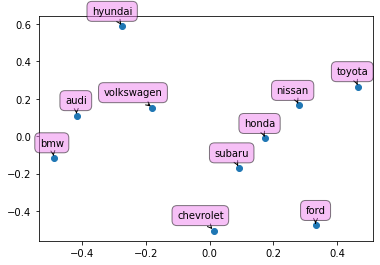

In [19]:
#As stated in the instructions, used an external script for the MDS plot.
#MDS plot script credit to: https://github.com/pazhani1994
from matplotlib.font_manager import FontProperties
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(dissimilarity_matrix)

coords = results.embedding_
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
font0 = FontProperties()
font = font0.copy()

## Change the size of the font
## Sizes: ['xx-small', 'x-small', 'small', 'medium', 'large','x-large', 'xx-large']
font.set_size('medium')


for label, x, y in zip(top_ten_list, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (10, 10),
         fontproperties=font,
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'violet', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

## Attributes and Aspirations (Task C and Task E)

For attributes you guys can run a list or something to find the top 5. It's similar to how I found the top 5 brands. I already wrote some of the code to help you guys along.

In [20]:
#Create a list of attributes that we think belong to cars in the commercials
attribute_list = ['performance','luxury','reliable','safety','affordable','favorite','buy','speed','comfort',
                 'warranty','price','msrp','security','fuel','consumption','insurance','maintainence']
#Feel free to append or add more to the list
#attribute_list.append('Phrase here')

In [21]:
attribute_df = pd.DataFrame(index = attribute_list)

In [22]:
attribute_df['frequency'] = 0

In [23]:
attribute_df

,frequency
performance,0
luxury,0
reliable,0
safety,0
affordable,0
favorite,0
buy,0
speed,0
comfort,0
warranty,0


In [24]:
#Count the number of times a brand has been mentioned in a message/comment throughout the entire df
for dictionary in commercials_df['count dictionary']: #Take each dictionary
    for key,value in dictionary.items(): #For each key (word) and value (frequency)
        if key in attribute_list: #The key matches a word in the attribute list.
            #Add 1 to the value of the word it matched in the dataframe.
            attribute_df.loc[key] += 1

In [25]:
attribute_df

,frequency
performance,42
luxury,60
reliable,28
safety,19
affordable,6
favorite,39
buy,222
speed,41
comfort,0
warranty,17


In [26]:
top_five_attributes = attribute_df.sort_values('frequency',ascending = False).head(5)

In [27]:
top_five_attributes

,frequency
buy,222
price,90
luxury,60
performance,42
speed,41


Afterwhich, you guys can just do what I did with the lift matrix. Note: needs to be 5 brands.